# Basic Usage

To use `torch_mist` in a project:

In [1]:
import torch_mist

print(torch_mist.__version__)

0.1.2


## Data

We first define a simple dataset that returns pairs of samples from a bivariate normal distribution.

In [2]:
import torch
from torch.distributions import MultivariateNormal, Normal

rho = 0.9
cov = torch.tensor([
    [1, rho], 
    [rho, 1.]
])
mean = torch.tensor([0., 0.])
x_dim = y_dim = n_dim = 1

p_xy = MultivariateNormal(
    mean,
    cov
)

p_x = p_y = Normal(0, 1)

true_mi = (
        p_x.entropy() + p_y.entropy() - p_xy.entropy()
).sum().item()

print(f"True Mutual Information: {true_mi} nats")

True Mutual Information: 0.8303654193878174 nats


Visualization of the samples

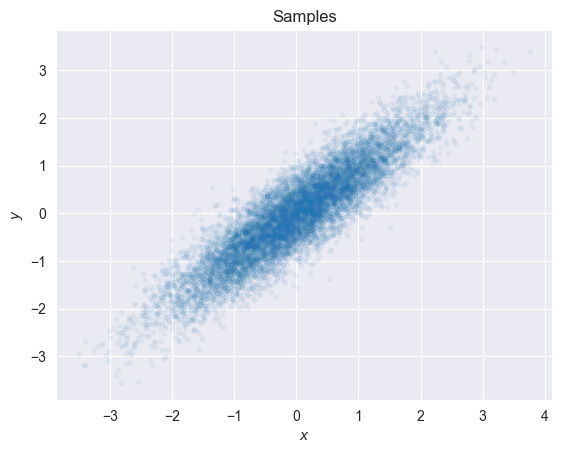

In [3]:
import matplotlib.pyplot as plt

samples = p_xy.sample([100000])

x = samples[:,0]
y = samples[:,1]

plt.scatter(
    x[::10], y[::10],
    marker='.',
    alpha=0.05
)

plt.title("Samples")
plt.xlabel('$x$')
plt.ylabel('$y$');

## Defining and training the estimator

In [4]:
from torch_mist import estimate_mi

mi_estimate, estimator, train_log = estimate_mi(
    estimator_name='js',
    x=x,
    y=y,
    train_batch_size=128,
    evaluation_batch_size=256,
    device='cpu',
    hidden_dims=[128,32],
    neg_samples=16,
    return_estimator=True,
    return_log=True,
)

Instantiating the js estimator
JS(
  (ratio_estimator): JointCritic(
    (joint_net): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=32, bias=True)
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
      (f): ReLU(inplace=True)
    )
  )
  (baseline): ConstantBaseline()
  (neg_samples): 16
)
Training the estimator


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/625 [00:00<?, ?it/s]

No improvements on validation, stopping.
Evaluating the value of Mutual Information


(1.0, 8.35)

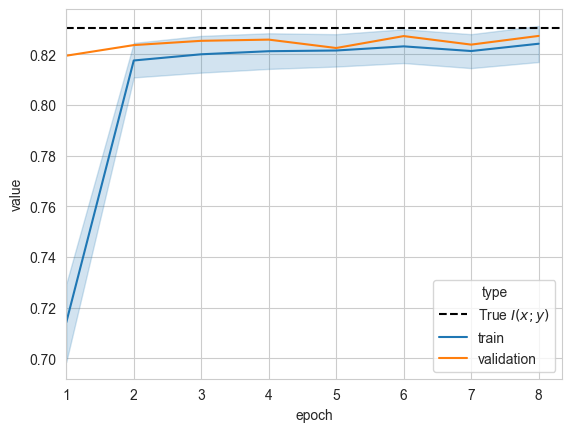

In [7]:
import seaborn as sns
sns.set_style('whitegrid')

plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
sns.lineplot(train_log, x='epoch', y='value', hue='type')
plt.xlim(1)

In [8]:
print(f"Estimated Mutual Information: {mi_estimate} nats")
print(f"True Mutual Information: {true_mi} nats")

Estimated Mutual Information: 0.8245928197565591 nats
True Mutual Information: 0.8303654193878174 nats


# Advanced Usage

Instead of using the `estimate_mi` function directly, it is possible to manually instantiate the estimators and specify additional details for the training and evaluation procedures.
 
## Instantiating the estimator
We start by defining a simple mutual information estimator based on Deep-InfoMax (JS) with joint critic architecture.

In [9]:
from torch_mist.estimators import JS
from torch_mist.critic import JointCritic
from torch import nn

# First we define a critic network that maps pairs of samples to a scalar
critic = JointCritic(
    joint_net=nn.Sequential(
        nn.Linear(x_dim + y_dim, 64),
        nn.ReLU(True),
        nn.Linear(64, 64),
        nn.ReLU(True),
        nn.Linear(64, 1),
    )
)

# We also specify the number of Monte Carlo samples to use for the estimation of the partition function
neg_samples = 16

# Then we pass it to the Jensen-Shannon estimator
estimator = JS(
    critic=critic,
    neg_samples=neg_samples
)

print(estimator)

JS(
  (ratio_estimator): JointCritic(
    (joint_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (baseline): ConstantBaseline()
  (neg_samples): 16
)


## Training
We now define the dataloaders, optimizer and train the estimator with a simple training loop

In [10]:
from tqdm.autonotebook import tqdm
from torch.optim import AdamW
from torch_mist.utils.data import SampleDataset
from torch.utils.data import DataLoader

# We use a simple wrapper to make a torch.utils.data.Dataset object using the pairs of x and y
dataset = SampleDataset({'x': x, 'y': y})

# Then we make a dataloader
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True
)

# Use the AdamW optimizer with a learning rate of 5e-4
opt = AdamW(estimator.parameters(), lr=5e-4)

# Train for 3 epochs
n_epochs = 3

# Create an empty log to visualize the training progress
log = []

# For each epoch
for epoch in range(n_epochs):
    for data in tqdm(dataloader):
        x, y = data['x'], data['y']
        
        # Compute the loss
        loss = estimator.loss(x, y)
        
        # And the corresponding estimation of Mutual Information
        mi = estimator(x, y)

        # Reset the gradients
        opt.zero_grad()
        # Backpropagate
        loss.backward()
        # Update the parameters
        opt.step()

        # Log the loss
        log.append({
            'iteration': len(log),
            'loss': loss.item(),
            'estimate': mi.item()
        })


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

## Visualization
We can plot loss and estimated mutual information over time

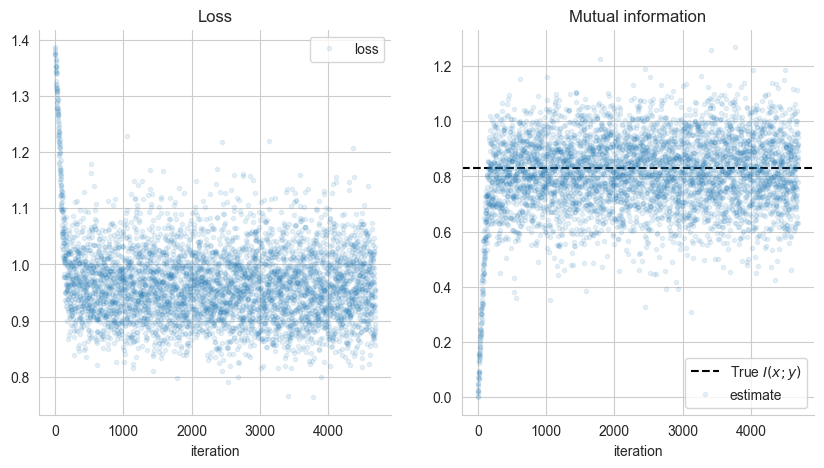

In [11]:
import pandas as pd

f, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.axhline(y=true_mi, ls='--', color='k', label='True $I(x;y)$')
pd.DataFrame(log).plot(x='iteration', y='loss', ax=ax[0], marker='.', ls='', alpha=0.1)
pd.DataFrame(log).plot(x='iteration', y='estimate', ax=ax[1], marker='.', ls='', alpha=0.1)

ax[0].set_title('Loss')
ax[1].set_title('Mutual information')
ax[1].legend()

sns.despine()

## Evaluation
We can now evaluate the estimator on the entire dataset

In [14]:
import numpy as np

mi_estimates = []
for data in tqdm(dataloader):
    mi_estimates.append(estimator(data['x'], data['y']).item())

print(f"Estimated Mutual Information: {np.mean(mi_estimates)} nats")
print(f"True Mutual Information: {true_mi} nats")


  0%|          | 0/1563 [00:00<?, ?it/s]

Estimated Mutual Information: 0.8216359116332469 nats
True Mutual Information: 0.8303654193878174 nats
